In [1]:
!pip install nltk
import nltk; nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import string
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
!pip install pyldavis
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from wordcloud import WordCloud

You should consider upgrading via the '/Users/cbeams/.pyenv/versions/3.8.12/envs/objectively_funny/bin/python -m pip install --upgrade pip' command.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cbeams/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


You should consider upgrading via the '/Users/cbeams/.pyenv/versions/3.8.12/envs/objectively_funny/bin/python -m pip install --upgrade pip' command.


In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [3]:
# Import Dataset
df = pd.read_json('../raw_data/all_data_df_stripped.json')
df.head()

full_transcript       artist  \
0  [rock music playing]\n\n[indistinct chatter]\n...  Adam Devine   
1    strong language. CHEERING Yes, yes, yes! How...    Adam Hess   
2   Ladies and gentlemen, please welcome your hos...   Adam Hills   
3    some strong language and adult humour Ladies...   Adam Hills   
4  ? CHEERING Hello, Apollo. I am going to start ...   Adam Hills   

                                show_name    year                source  \
0                  Best Time Of Our Lives  2019.0  Scraps from the Loft   
1                       Live from the BBC  2016.0                   BBC   
2   Live at the Apollo Series 9 Episode 4  2013.0                   BBC   
3  Live at the Apollo Series 12 Episode 4  2016.0                   BBC   
4   Live at the Apollo Series 5 Episode 5  2009.0                   BBC   

   artist_birthday  artist_gender  age_then  \
0           1983.0              2      36.0   
1           1990.0              2      26.0   
2           1970.0              2      43.0   
3           1970.0              2      46.0   
4           1970.0              2      39.0   

                               full_transcript_clean  
0  man guy much seat guy jacked fully juiced man ...  
1  yes yes yes lovely apologise state voice go co...  
2  tonight london london live amazing act present...  
3  tonight hair lost bet british paralympic team ...  
4  start saying something probably never heard co...

In [4]:
oughties_df = df[df['year'].between(2000, 2010)]

In [5]:
oughties_df.head()

full_transcript            artist  \
4   ? CHEERING Hello, Apollo. I am going to start ...        Adam Hills   
9    Ladies and gentlemen, please welcome your hos...         Al Murray   
10   Ladies and gentlemen, please welcome your hos...         Al Murray   
17   Ladies and gentlemen, please welcome your hos...  Alistair McGowan   
42  Recorded on July 1, 2009 at The Brentwood Thea...       Aziz Ansari   

                                 show_name    year                source  \
4    Live at the Apollo Series 5 Episode 5  2009.0                   BBC   
9    Live at the Apollo Series 4 Episode 2  2008.0                   BBC   
10   Live at the Apollo Series 5 Episode 3  2009.0                   BBC   
17   Live at the Apollo Series 5 Episode 6  2010.0                   BBC   
42  Intimate Moments For A Sensual Evening  2010.0  Scraps from the Loft   

    artist_birthday  artist_gender  age_then  \
4            1970.0              2      39.0   
9            1968.0              2      40.0   
10           1968.0              2      41.0   
17           1964.0              2      46.0   
42           1983.0              2      27.0   

                                full_transcript_clean  
4   start saying something probably never heard co...  
9   tonight pub landlord whoa shake hand shake han...  
10  tonight pub landlord another bite dust another...  
17  tonight much indeed good evening live yes inde...  
42  july brentwood theatre los angeles whoa whoa w...

In [6]:
# Convert to list
data = oughties_df.full_transcript_clean.values.tolist()

pprint(data[:1])

['start saying something probably never heard comedian love american boo '
 'thanks reckon american optimistic people planet american child personality '
 'trait hope grow american street kid faith faith seen hope yes charity '
 'waiting honor australian imagine australian guy naming kid way hope grow '
 'gday son top bloke son opening batsman daughter big tit america given '
 'olympic female swimmer couple year ago misty hyman last hyman call child '
 'adjective parent must birth last hyman shall call daughter misty '
 'embarrassing brother rusty seem mind good thinking dick show american woman '
 'came afterwards joke american name american diabetic candy great travelling '
 'matter world music bond anyone age separate example people grew music seeing '
 'responds ohh ohhh ohh ohhh nice work bit kung fighting usually bloke back '
 'occasionally woman front dee dee dee bad lyric kung fighting cat fast '
 'lightning fact little bit frightening fought expert timing last shit rhyming '
 

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['start', 'saying', 'something', 'probably', 'never', 'heard', 'comedian', 'love', 'american', 'boo', 'thanks', 'reckon', 'american', 'optimistic', 'people', 'planet', 'american', 'child', 'personality', 'trait', 'hope', 'grow', 'american', 'street', 'kid', 'faith', 'faith', 'seen', 'hope', 'yes', 'charity', 'waiting', 'honor', 'australian', 'imagine', 'australian', 'guy', 'naming', 'kid', 'way', 'hope', 'grow', 'gday', 'son', 'top', 'bloke', 'son', 'opening', 'batsman', 'daughter', 'big', 'tit', 'america', 'given', 'olympic', 'female', 'swimmer', 'couple', 'year', 'ago', 'misty', 'hyman', 'last', 'hyman', 'call', 'child', 'adjective', 'parent', 'must', 'birth', 'last', 'hyman', 'shall', 'call', 'daughter', 'misty', 'embarrassing', 'brother', 'rusty', 'seem', 'mind', 'good', 'thinking', 'dick', 'show', 'american', 'woman', 'came', 'afterwards', 'joke', 'american', 'name', 'american', 'diabetic', 'candy', 'great', 'travelling', 'matter', 'world', 'music', 'bond', 'anyone', 'age', 'sepa

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=5) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=5)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['start', 'saying', 'something', 'probably', 'never_heard', 'comedian', 'love', 'american', 'boo', 'thanks', 'reckon', 'american', 'optimistic', 'people', 'planet', 'american', 'child', 'personality', 'trait', 'hope', 'grow', 'american', 'street', 'kid', 'faith', 'faith', 'seen', 'hope', 'yes', 'charity', 'waiting', 'honor', 'australian', 'imagine', 'australian', 'guy', 'naming', 'kid', 'way', 'hope', 'grow', 'gday', 'son', 'top', 'bloke', 'son', 'opening', 'batsman', 'daughter', 'big', 'tit', 'america', 'given', 'olympic', 'female', 'swimmer', 'couple_year_ago', 'misty', 'hyman', 'last', 'hyman', 'call', 'child', 'adjective', 'parent', 'must', 'birth', 'last', 'hyman', 'shall', 'call', 'daughter', 'misty', 'embarrassing', 'brother', 'rusty', 'seem', 'mind', 'good', 'thinking', 'dick', 'show', 'american', 'woman', 'came', 'afterwards', 'joke', 'american', 'name', 'american', 'diabetic', 'candy', 'great', 'travelling', 'matter', 'world', 'music', 'bond', 'anyone', 'age', 'separate', 'ex

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['start', 'say', 'probably', 'comedian', 'thank', 'reckon', 'optimistic', 'people', 'planet', 'american', 'child', 'personality', 'trait', 'hope', 'grow', 'american', 'street', 'kid', 'faith', 'faith', 'see', 'hope', 'charity', 'wait', 'honor', 'australian', 'imagine', 'australian', 'guy', 'name', 'way', 'hope', 'grow', 'gday', 'son', 'top', 'bloke', 'son', 'opening', 'batsman', 'daughter', 'big', 'give', 'olympic', 'female', 'swimmer', 'couple_year', 'ago', 'hyman', 'last', 'hyman', 'call', 'child', 'adjective', 'parent', 'birth', 'last', 'hyman', 'call', 'misty', 'embarrassing', 'brother', 'seem', 'mind', 'good', 'thinking', 'american', 'woman', 'come', 'afterwards', 'candy', 'great', 'travel', 'matter', 'world', 'music', 'bond', 'age', 'separate', 'example', 'people', 'grow', 'music', 'see', 'respond', 'ohh', 'ohhh', 'ohh', 'ohhh', 'nice', 'work', 'bit', 'kung', 'fighting', 'usually', 'bloke', 'back', 'occasionally', 'woman', 'front', 'bad', 'lyric', 'kung', 'fight', 'cat', 'fast',

In [11]:
def remove_stopw(text, word_list):
    for i in range(len(text)):
        text[i] = [w for w in text[i] if not w in word_list]
    return text

In [19]:
### additional words to remove from the scripts
words_to_remove = ['thank', 'cheering', 'recorded', 'applause', 'laughter', 'laughing', 'murmuring', 'chatter',
                       'aired', 'filmed', 'ladies', 'gentlemen', 'welcome', 'stage', 'transcript', 'netflix',
                  'apollo', 'like', 'goodnight', 'mutter', 'noo', 'nuh', 'oof', 'maan', 'cause', 'okay', 
                   'hey', 'also', 'someone', 'somebody', 'everybody', 'also', 'part' , 'sometimes', 'maybe', 
                   'three', 'second', 'everything', 'minute', 'name', 'kind', 'point', 'yeah', 'hello', 'one', 
                   'two', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'whine', 'hnn', 'malla', 'letta', 
                   'namoo', 'getta', 'nama', 'mana', 'chk','manoo', 'hadda', 'ama', 'carlin',
                  'go', 'know', 'host', 'goodnight', 'get', 'gon', 'think', 'say', 'right', 'look',
                  'thing', 'make', 'know', 'want', 'going', 'would', 'could', 'gentlemen', 'let', 'please',
                   'hbo', 'special' 'yes', 'take', 'say', 'got', 'come', 'see', 'really', 'tell',
                   'well', 'give', 'said', 'people', 'mean', 'even', 'never', 'way', 'happen', 'put', 'much',
                  'lot', 'ever', 'still', 'live', 'quite', 'sort', 'actually', 'use', 'tonight', 'find', 'always',
                  'time', 'good', 'back', 'show', 'little', 'big', 'day', 'talk', 'start', 'need', 'bad', 'first', 'great',
                  'try', 'year', 'word', 'turn', 'bring', 'feel', 'bit', 'ck', 'cke', 'gger', 'ckin', 'groan', 'groan_low', 'groan_high',
                  'high_groan', 'low_groan', 'dingdingde']
                    
decade_cleanup = ['fuck', 'fucking', 'shit', 'motherfucker', 'man', 'woman', 'guy']
                    
                    # 'know'? 'go'? 'fuck'?
    
                    # haven't left 'i'm' etc. as those should be cleaned up
                    # by a mixture of stopwords, punctuation removeal, lemmatizing and minimum length

remove_stopw(data_lemmatized, stopwords.words('english'))
remove_stopw(data_lemmatized, words_to_remove)
remove_stopw(data_lemmatized, decade_cleanup)

[['probably',
  'comedian',
  'reckon',
  'optimistic',
  'planet',
  'american',
  'child',
  'personality',
  'trait',
  'hope',
  'grow',
  'american',
  'street',
  'kid',
  'faith',
  'faith',
  'hope',
  'charity',
  'wait',
  'honor',
  'australian',
  'imagine',
  'australian',
  'hope',
  'grow',
  'gday',
  'son',
  'top',
  'bloke',
  'son',
  'opening',
  'batsman',
  'daughter',
  'olympic',
  'female',
  'swimmer',
  'couple_year',
  'ago',
  'hyman',
  'last',
  'hyman',
  'call',
  'child',
  'adjective',
  'parent',
  'birth',
  'last',
  'hyman',
  'call',
  'misty',
  'embarrassing',
  'brother',
  'seem',
  'mind',
  'thinking',
  'american',
  'afterwards',
  'candy',
  'travel',
  'matter',
  'world',
  'music',
  'bond',
  'age',
  'separate',
  'example',
  'grow',
  'music',
  'respond',
  'ohh',
  'ohhh',
  'ohh',
  'ohhh',
  'nice',
  'work',
  'kung',
  'fighting',
  'usually',
  'bloke',
  'occasionally',
  'front',
  'lyric',
  'kung',
  'fight',
  'cat',


In [20]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 4), (9, 1), (10, 3), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 2), (17, 1), (18, 2), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 3), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 2), (51, 2), (52, 1), (53, 2), (54, 1), (55, 2), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 3), (62, 1), (63, 9), (64, 1), (65, 2), (66, 1), (67, 2), (68, 9), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 3), (76, 2), (77, 3), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 2), (85, 3), (86, 1), (87, 1), (88, 3), (89, 1), (90, 1), (91, 4), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 2), (102, 1), (103, 1), (104, 1), (105, 1), (106, 2), (107, 1), (108, 2), (109, 2), (110, 1)

In [21]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=31,
                                            random_state=100,
                                            update_every=10,
                                            chunksize=15,
                                            passes=10,
                                            alpha=0.4,
                                            eta=0.5,
                                            per_word_topics=True)

In [22]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(8,
  '0.000*"call" + 0.000*"work" + 0.000*"kid" + 0.000*"leave" + 0.000*"life" + '
  '0.000*"love" + 0.000*"country" + 0.000*"girl" + 0.000*"watch" + '
  '0.000*"walk"'),
 (6,
  '0.002*"wedding" + 0.001*"blasphemy" + 0.001*"covered_sick" + '
  '0.001*"cat_sfeet" + 0.001*"pitbull" + 0.001*"stew" + 0.001*"towel" + '
  '0.001*"wed" + 0.001*"thirdlength_floralprint" + 0.001*"twilight"'),
 (25,
  '0.000*"kid" + 0.000*"love" + 0.000*"call" + 0.000*"walk" + 0.000*"work" + '
  '0.000*"life" + 0.000*"old" + 0.000*"keep" + 0.000*"girl" + 0.000*"sit"'),
 (14,
  '0.000*"call" + 0.000*"work" + 0.000*"watch" + 0.000*"kid" + 0.000*"run" + '
  '0.000*"life" + 0.000*"love" + 0.000*"stop" + 0.000*"car" + 0.000*"hear"'),
 (5,
  '0.000*"love" + 0.000*"kid" + 0.000*"life" + 0.000*"work" + 0.000*"child" + '
  '0.000*"call" + 0.000*"keep" + 0.000*"head" + 0.000*"watch" + 0.000*"run"'),
 (2,
  '0.000*"call" + 0.000*"love" + 0.000*"kid" + 0.000*"work" + 0.000*"play" + '
  '0.000*"sit" + 0.000*"walk" + 0.000*

In [23]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.385442475486402

Coherence Score:  0.2814170903221219


In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds='mmds')
vis

/Users/cbeams/.pyenv/versions/3.8.12/envs/objectively_funny/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
19     0.066077  0.210472       1        1  94.966231
7      0.047988 -0.010458       2        1   2.318852
6     -0.013889 -0.002628       3        1   0.516322
3     -0.005749  0.003531       4        1   0.434922
30     0.004474 -0.011368       5        1   0.378108
18     0.001940 -0.007573       6        1   0.249233
9     -0.003129 -0.004089       7        1   0.157183
17    -0.005665 -0.008914       8        1   0.106595
11    -0.005041 -0.006553       9        1   0.089887
21    -0.003447 -0.006677      10        1   0.081632
16    -0.003194 -0.006871      11        1   0.067677
20    -0.004070 -0.006627      12        1   0.059435
10    -0.004182 -0.007243      13        1   0.042299
29    -0.003905 -0.007108      14        1   0.029573
23    -0.003887 -0.007307      15        1   0.029566
22    -0.003940 -0.007302      16        1   0.029556
13    -0.003981 -0.007405      17        1   0.029545
25    -0.004005 -0.007421      18        1   0.029541
4     -0.003968 -0.007466      19        1   0.029539
2     -0.003977 -0.007462      20        1   0.029536
1     -0.004020 -0.007500      21        1   0.029535
0     -0.004008 -0.007559      22        1   0.029533
26    -0.004001 -0.007506      23        1   0.029531
24    -0.004021 -0.007546      24        1   0.029529
28    -0.004047 -0.007562      25        1   0.029529
27    -0.004034 -0.007599      26        1   0.029524
5     -0.004040 -0.007624      27        1   0.029522
15    -0.004061 -0.007612      28        1   0.029521
8     -0.004044 -0.007626      29        1   0.029520
12    -0.004076 -0.007686      30        1   0.029515
14    -0.004097 -0.007713      31        1   0.029511, topic_info=       Term        Freq       Total Category  logprob  loglift
91     love  691.000000  691.000000  Default  30.0000  30.0000
83      kid  617.000000  617.000000  Default  29.0000  29.0000
21     call  614.000000  614.000000  Default  28.0000  28.0000
163    work  550.000000  550.000000  Default  27.0000  27.0000
88     life  473.000000  473.000000  Default  26.0000  26.0000
...     ...         ...         ...      ...      ...      ...
388    play    0.004154  376.014753  Topic31  -9.1321  -3.2851
263     end    0.004075  292.176884  Topic31  -9.1514  -3.0521
301    hard    0.003984  248.609971  Topic31  -9.1740  -2.9132
1090  sorry    0.003906  195.219285  Topic31  -9.1936  -2.6911
1433   head    0.004025  315.972764  Topic31  -9.1636  -3.1427

[2188 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
169        1  1.096822    accountanttax
4905       1  1.098841         achiever
171        1  1.096312  actuallypartner
4906       1  0.821956         adequate
173        1  1.096130        agreeable
...      ...       ...              ...
746        1  1.101375           yesyou
9443       1  0.983778     young_people
491        1  1.044485              zey
11899      1  1.087507              zis
1945       1  1.010865              zit

[831 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 8, 7, 4, 31, 19, 10, 18, 12, 22, 17, 21, 11, 30, 24, 23, 14, 26, 5, 3, 2, 1, 27, 25, 29, 28, 6, 16, 9, 13, 15])

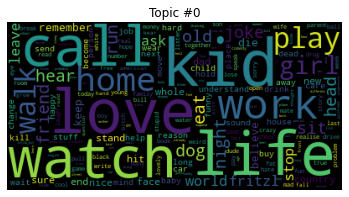

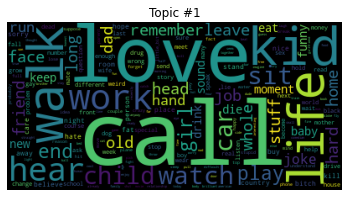

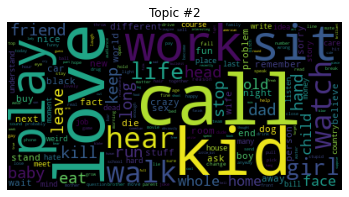

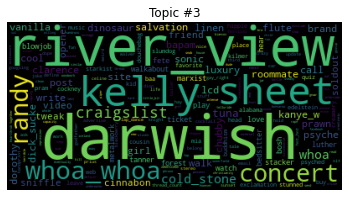

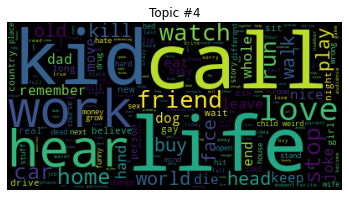

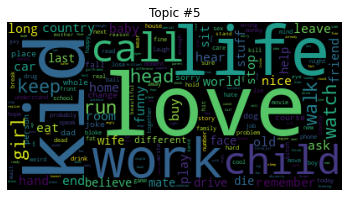

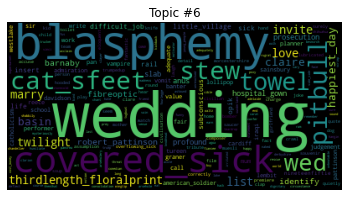

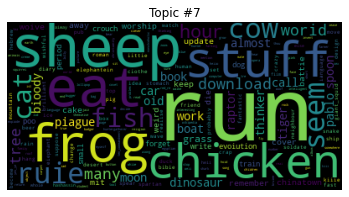

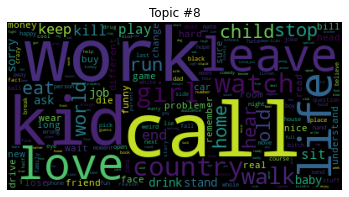

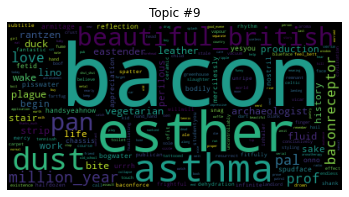

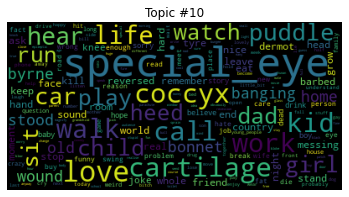

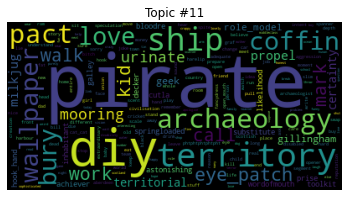

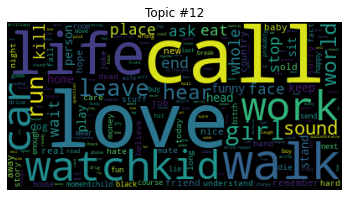

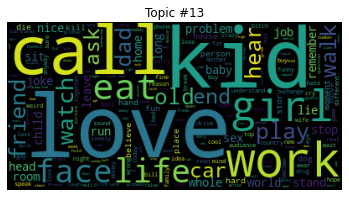

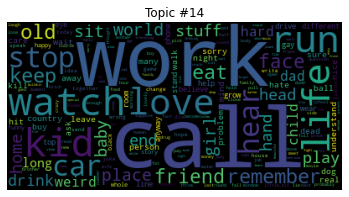

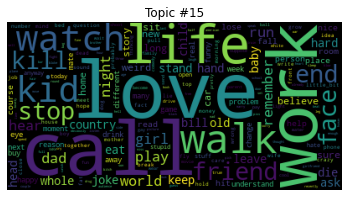

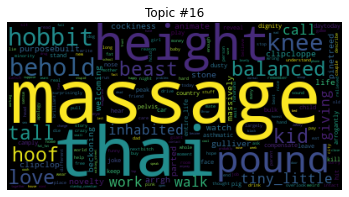

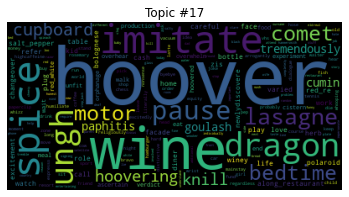

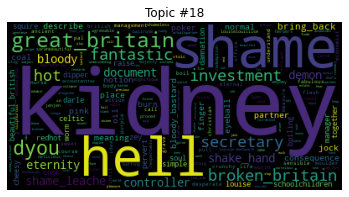

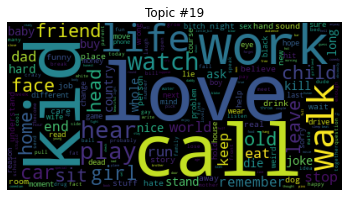

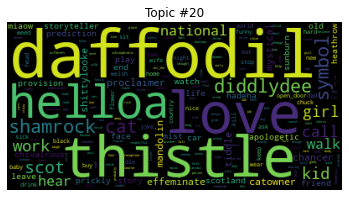

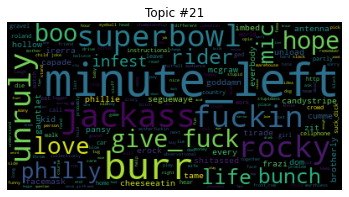

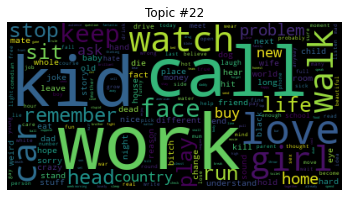

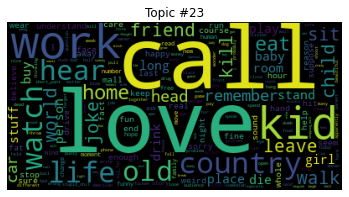

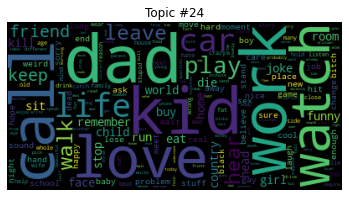

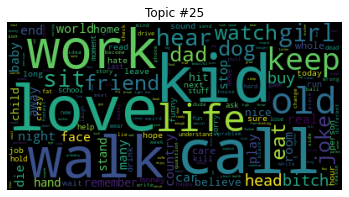

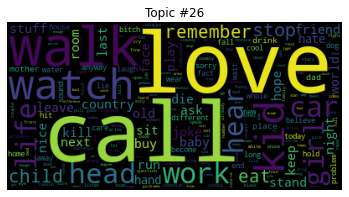

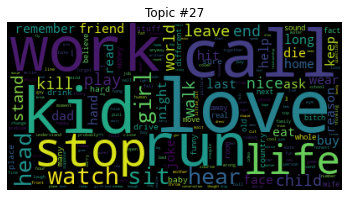

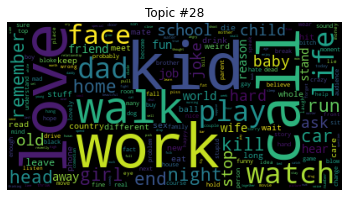

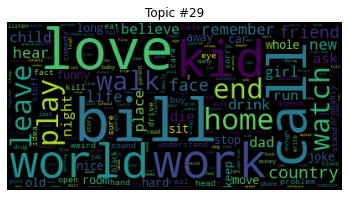

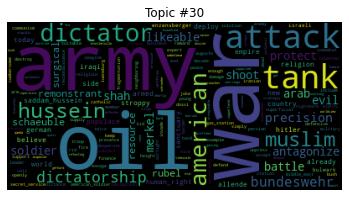

In [25]:
# lda is assumed to be the variable holding the LdaModel object
import matplotlib.pyplot as plt
for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()